In [74]:
import numpy as np
import matplotlib.pyplot as plt
from helper import *
from gauss_sadel import Gauss_Sadel
from tqdm import tqdm

## Inputs ###################

dx = 0.02
dy = 0.01

Lx = 1
Ly = 0.5

num_nodes_x = int(Lx / dx)
num_nodes_y = int(Ly / dy)

# For equidistant change it to 0, 0
x_percentage = 0 # reduce by {x_percentage}%
y_percentage = 0 # reduce by {y_percentage}%

index_x = 0
index_y = 0

### Boundary Conditions
# T South : Temperature | 15
# T East  : Flux        | 5000
# T North : Temperature | 10
# T West  : Insulated   | 

q_E       = -5000  # uniform heat generation

T_N       = 10 # North Side
T_S       = 15

H = 0.5

##############################

class node:
    def __init__(self):

        self.idx = None # Idx starts with 1 (i messed up)
        self.node_pos = None
        self.Cell_size_x = 5
        self.Cell_size_y = 5
        self.grid_face = None
        self.node_type = None 

        self.Gx = None # Location along the x axis
        self.Gy = None # Location along the y axis

        self.edge_color = "blue"

        self.edge_node_pos = []
        #    1
        # 0|   | 2
        #    3

        self.del_xe = None
        self.del_xn = None
        self.del_xw = None
        self.del_xs = None

# Initializing empty mesh
mesh = np.array([[node() for x in range(num_nodes_x)] for y in range(num_nodes_y)])

# Equidistant mesh gets created here
x_val = 0
y_val = 0

# the origin of the x and y axis is on the bottom left
idx = 0
for y in range(mesh.shape[0]):
    for x in range(mesh.shape[1]):
        cell = mesh[y][x]
        cell.idx = idx
        cell.Gx = x_val
        cell.Gy = y_val

        if y == 0: cell.edge_node_pos.append(3)
        if x == 0: cell.edge_node_pos.append(0)
        if x == (Ly/dy) - 1 : cell.edge_node_pos.append(2)
        if y == (Lx/dx) - 1 : cell.edge_node_pos.append(1)

        x_val += cell.Cell_size_x
        idx += 1
    x_val = 0
    y_val += cell.Cell_size_y

def strech_mesh(mesh: np.array, x_percentage, y_percentage, strech_function, index_x, index_y):
    if x_percentage == 0 and y_percentage == 0: # Edge case
        return mesh
    
    # Stretch in x
    if x_percentage != 0:
        for y in range(mesh.shape[0]):
            x_array_size = [mesh[y][x].Cell_size_x for x in range(mesh.shape[1])]
            stretched_array_size = strech_function(x_array_size, index_x, x_percentage)
            for x in range(mesh.shape[1]):
                mesh[y][x].Cell_size_x = stretched_array_size[x]

    # Stretch in y
    if y_percentage != 0:
        for x in range(mesh.shape[1]):
            y_array_size = [mesh[y][x].Cell_size_y for y in range(mesh.shape[0])]
            stretched_array_size = strech_function(y_array_size, index_y, y_percentage)
            for y in range(mesh.shape[0]):
                mesh[y][x].Cell_size_y = stretched_array_size[y]

    # Recompute coordinates AFTER both
    y_val = 0
    for y in range(mesh.shape[0]):
        x_val = 0
        for x in range(mesh.shape[1]):
            mesh[y][x].Gx = x_val
            mesh[y][x].Gy = y_val
            x_val += mesh[y][x].Cell_size_x
        y_val += mesh[y][0].Cell_size_y

    return mesh 

mesh = strech_mesh(mesh, x_percentage, y_percentage, strech_function = degrade_percentage, index_x=index_x, index_y=index_y)   


In [75]:
mesh.shape

(50, 50)

In [76]:
for y in range(num_nodes_y):
    for x in range(num_nodes_x):

        cell = mesh[y][x]
        if y == 0:
            cell.del_xn = cell.Cell_size_y/2
            cell.del_xs = mesh[y][x].Cell_size_y/2 + mesh[y+1][x].Cell_size_y/2
            if x == 0:
                cell.del_xw = cell.Cell_size_x/2
                cell.del_xe = mesh[y][x].Cell_size_x/2 + mesh[y][x+1].Cell_size_x/2

            elif x == len(mesh[0])-1:
                cell.del_xe = cell.Cell_size_x/2  
                cell.del_xw = mesh[y][x].Cell_size_x/2 + mesh[y][x-1].Cell_size_x/2
            
            else: # non edge case 
                cell.del_xw = mesh[y][x].Cell_size_x/2 + mesh[y][x-1].Cell_size_x/2   
                cell.del_xe = mesh[y][x].Cell_size_x/2 + mesh[y][x+1].Cell_size_x/2

        if y == mesh.shape[0]-1:
            cell.del_xs = cell.Cell_size_y/2 
            cell.del_xn = mesh[y][x].Cell_size_y/2 + mesh[y-1][x].Cell_size_y/2

            if x == 0:
                cell.del_xw = cell.Cell_size_x/2
                cell.del_xe = mesh[y][x].Cell_size_x/2 + mesh[y][x+1].Cell_size_x/2
           
            elif x == len(mesh[0])-1:
                cell.del_xe = cell.Cell_size_x/2  
                cell.del_xw = mesh[y][x].Cell_size_x/2 + mesh[y][x-1].Cell_size_x/2
            
            else: # non edge case 
                cell.del_xw = mesh[y][x].Cell_size_x/2 + mesh[y][x-1].Cell_size_x/2   
                cell.del_xe = mesh[y][x].Cell_size_x/2 + mesh[y][x+1].Cell_size_x/2

        else:
            cell.del_xn = mesh[y][x].Cell_size_y/2 + mesh[y-1][x].Cell_size_y/2   
            cell.del_xs = mesh[y][x].Cell_size_y/2 + mesh[y+1][x].Cell_size_y/2   
            if x == 0:
                cell.del_xw = cell.Cell_size_x/2
                cell.del_xe = mesh[y][x].Cell_size_x/2 + mesh[y][x+1].Cell_size_x/2

            elif x == mesh.shape[1]-1:
                cell.del_xe = cell.Cell_size_x/2
                cell.del_xw = mesh[y][x].Cell_size_x/2 + mesh[y][x-1].Cell_size_x/2   
                
            else: # non edge case 
                cell.del_xw = mesh[y][x].Cell_size_x/2 + mesh[y][x-1].Cell_size_x/2   
                cell.del_xe = mesh[y][x].Cell_size_x/2 + mesh[y][x+1].Cell_size_x/2    

In [77]:
delta_x = [] # size of the cell in x direction
delta_y = [] # size of the cell in y direction

for y in range(len(mesh)):
    delta_x_temp = []
    delta_y_temp = []
    for x in range(len(mesh[0])):
        cell = mesh[y][x]
        delta_x_temp.append(cell.Cell_size_x)
        delta_y_temp.append(cell.Cell_size_y)
    delta_x.append(delta_x_temp)
    delta_y.append(delta_x_temp)

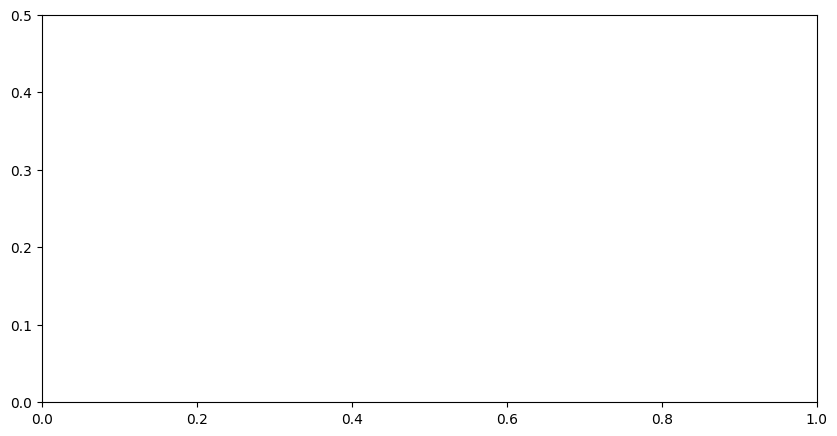

In [78]:
plot_mesh(mesh, Ly, Lx)

In [79]:
nodes = []
n = 1
for i in range(int(num_nodes_x)):
    l = []
    for j in range(int(num_nodes_y)):
        l.append(n)
        n+=1
    nodes.append(l)

# nodes = nodes[::-1]
nodes = np.fliplr(np.array(nodes)).transpose()
nodes = np.array(nodes)

for i in range(int(num_nodes_y)):
    for j in range(int(num_nodes_x)):
        mesh[i][j].idx = nodes[i][j]

In [80]:
coef_matrix = np.zeros((num_nodes_y*num_nodes_x, num_nodes_y*num_nodes_x))
Su_vector = np.zeros_like(coef_matrix[:,0])
coef_matrix.shape

(2500, 2500)

In [81]:
for node_idx in range(num_nodes_x * num_nodes_y):
    # print(f"Processing node {node_idx}")
    cell_x, cell_y = linear_to_flipped_coords(node_idx, num_nodes_y)
    cell_x, cell_y = int(cell_x), int(cell_y)

    # For mesh[y][x] indexing
    cell = mesh[cell_x][cell_y]
    # print(f"Coordinates: ({cell_x}, {cell_y})")

    nei_dict = find_neighbors(nodes, cell_x, cell_y, num_nodes_x, num_nodes_y)
    # print(f"Neighbors: {nei_dict}")

    # Initialize coefficients
    a_N = a_S = a_E = a_W = 0
    Su = 0

    # -----------------------------
    # Variable conductivity at cell center
    k_cell = 16 * ((cell.Gy + (cell.Cell_size_y/2)) / H + 1)

    # Source term (uniform S = -1.5)
    Su += -1.5 * cell.Cell_size_x * cell.Cell_size_y
    # -----------------------------

    # === SOUTH boundary: Dirichlet T=15 ===
    if nei_dict['south'] is None and nei_dict['east'] is not None and nei_dict['west'] is not None:
        a_E = (k_cell * cell.Cell_size_y) / cell.del_xe
        a_N = (k_cell * cell.Cell_size_x) / cell.del_xn    
        a_W = (k_cell * cell.Cell_size_y) / cell.del_xw
        a_S = (k_cell * cell.Cell_size_x) / cell.del_xs   # half-cell treatment

        a_P = a_E + a_N + a_S + a_W
        Su += a_S * T_S

        coef_matrix[node_idx, node_idx] = a_P
        coef_matrix[node_idx, nei_dict['east'] - 1] = a_E
        coef_matrix[node_idx, nei_dict['north'] - 1] = a_N
        coef_matrix[node_idx, nei_dict['west'] - 1] = a_W

    # === NORTH boundary: Dirichlet T=10 ===
    elif nei_dict['north'] is None and nei_dict['east'] is not None and nei_dict['west'] is not None:
        a_E = (k_cell * cell.Cell_size_y) / cell.del_xe
        a_S = (k_cell * cell.Cell_size_x) / cell.del_xs
        a_W = (k_cell * cell.Cell_size_y) / cell.del_xw
        a_N = (k_cell * cell.Cell_size_x) / cell.del_xn  # half-cell treatment

        a_P = a_E + a_N + a_S + a_W
        Su += a_N * T_N

        coef_matrix[node_idx, node_idx] = a_P
        coef_matrix[node_idx, nei_dict['east'] - 1] = a_E
        coef_matrix[node_idx, nei_dict['south'] - 1] = a_S
        coef_matrix[node_idx, nei_dict['west'] - 1] = a_W

    # === EAST boundary: Neumann flux q=5000 ===
    elif nei_dict['east'] is None:
        a_N = (k_cell * cell.Cell_size_x) / cell.del_xn if nei_dict['north'] is None else (k_cell * cell.Cell_size_x) / cell.del_xn
        a_S = (k_cell * cell.Cell_size_x) / cell.del_xs if nei_dict['south'] is None else (k_cell * cell.Cell_size_x) / cell.del_xs
        a_W = (k_cell * cell.Cell_size_y) / cell.del_xw if nei_dict['west'] is not None else 0

        # Add Dirichlet contribution for top-right / bottom-right corners
        if nei_dict['north'] is None:
            Su += a_N * T_N
        if nei_dict['south'] is None:
            Su += a_S * T_S

        # Neumann flux contribution
        Su += q_E * cell.Cell_size_y

        a_P = a_N + a_S + a_W  # no east neighbor

        coef_matrix[node_idx, node_idx] = a_P
        if nei_dict['north'] is not None:
            coef_matrix[node_idx, nei_dict['north'] - 1] = a_N
        if nei_dict['south'] is not None:
            coef_matrix[node_idx, nei_dict['south'] - 1] = a_S
        if nei_dict['west'] is not None:
            coef_matrix[node_idx, nei_dict['west'] - 1] = a_W

    # === WEST boundary: Insulated ===
    elif nei_dict['west'] is None:
        if nei_dict['north'] is None:
            # top-left
            a_N = (k_cell * cell.Cell_size_x) / cell.del_xn # half-cell treatment
            a_S = (k_cell * cell.Cell_size_x) / cell.del_xs
            a_E = (k_cell * cell.Cell_size_y) / cell.del_xe
        
            Su += a_N * T_N

        elif nei_dict['south'] is None:
            # bottom-left
            a_N = (k_cell * cell.Cell_size_x) / cell.del_xn
            a_S = (k_cell * cell.Cell_size_x) / cell.del_xs # half-cell treatment
            a_E = (k_cell * cell.Cell_size_y) / cell.del_xe
            Su += a_S * T_S

        else:
            # middle of west boundary
            a_N = (k_cell * cell.Cell_size_x) / cell.del_xn
            a_S = (k_cell * cell.Cell_size_x) / cell.del_xs
            a_E = (k_cell * cell.Cell_size_y) / cell.del_xe

        a_W = 0  # insulated
        a_P = a_E + a_N + a_S

        coef_matrix[node_idx, node_idx] = a_P
        if nei_dict['north'] is not None:
            coef_matrix[node_idx, nei_dict['north'] - 1] = a_N
        if nei_dict['south'] is not None:
            coef_matrix[node_idx, nei_dict['south'] - 1] = a_S
        coef_matrix[node_idx, nei_dict['east'] - 1] = a_E

    # === INTERIOR node ===
    else:
        if nei_dict['north'] is not None:
            a_N = (k_cell * cell.Cell_size_x) / cell.del_xn
            coef_matrix[node_idx, nei_dict['north'] - 1] = a_N
        if nei_dict['south'] is not None:
            a_S = (k_cell * cell.Cell_size_x) / cell.del_xs
            coef_matrix[node_idx, nei_dict['south'] - 1] = a_S
        if nei_dict['east'] is not None:
            a_E = (k_cell * cell.Cell_size_y) / cell.del_xe
            coef_matrix[node_idx, nei_dict['east'] - 1] = a_E
        if nei_dict['west'] is not None:
            a_W = (k_cell * cell.Cell_size_y) / cell.del_xw
            coef_matrix[node_idx, nei_dict['west'] - 1] = a_W

        a_P = a_E + a_N + a_S + a_W
        coef_matrix[node_idx, node_idx] = a_P

    # === Update source vector ===
    Su_vector[node_idx] = Su
    # print(a_P, end="\n\n")


# Making non diagnol element negetive
mask = ~np.eye(coef_matrix.shape[0], dtype=bool)
coef_matrix[mask] = -coef_matrix[mask]



In [ ]:
X, loops_taken, relative_error_list = Gauss_Sadel(coef_matrix, Su_vector, np.zeros_like(Su_vector),
                             tolerance=1e-4, max_loops=100000)

  0%|          | 17/100000 [00:27<44:46:52,  1.61s/it]

In [ ]:
# tols = np.linspace(1e-1, 1e-5, 5)

# loops_taken_list = []
# for tol in tols:
#     X, loops_taken, relative_error_list = Gauss_Sadel(coef_matrix, Su_vector, np.zeros_like(Su_vector),
#                                 tolerance=tol, max_loops=100000)
#     loops_taken_list.append(loops_taken)

100%|██████████| 5/5 [06:27<00:00, 77.58s/it] 


In [ ]:
tols, loops_taken_list

(array([1.00000e-01, 7.50025e-02, 5.00050e-02, 2.50075e-02, 1.00000e-05]),
 [305, 350, 395, 581, 1652])

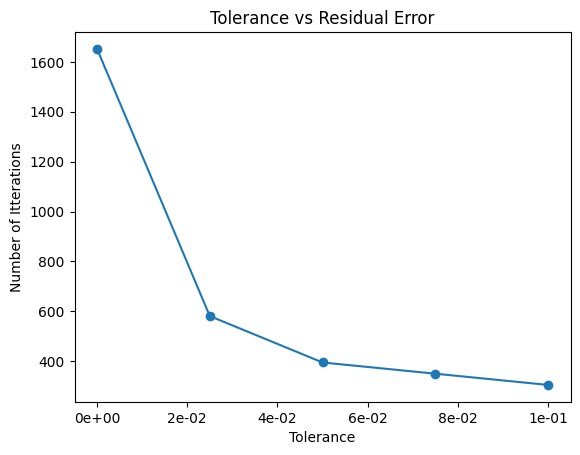

In [ ]:
# import matplotlib.ticker as ticker


# plt.plot(tols, loops_taken_list, marker = 'o')
# plt.ylabel("Number of Itterations")
# plt.xlabel("Tolerance")
# plt.title("Tolerance vs Residual Error")

# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0e}"))

# plt.show()

In [ ]:
# # Making non diagnol element negetive
# mask = ~np.eye(coef_matrix.shape[0], dtype=bool)
# coef_matrix[mask] = -coef_matrix[mask]


In [ ]:
# X, loops_taken = Gauss_Sadel(coef_matrix, Su_vector, np.zeros_like(Su_vector),
#                              tolerance=1e-4, max_loops=100)

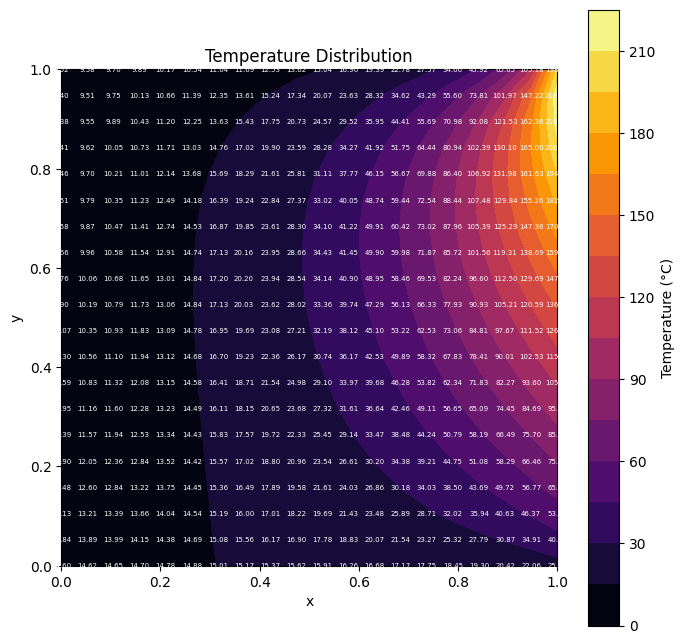

In [ ]:
# Reshape for 5×5 grid
X_grid = X.reshape(num_nodes_x, num_nodes_y).transpose()

# Create coordinates  
x = np.linspace(0, num_nodes_x*dx, num_nodes_x)
y = np.linspace(0, num_nodes_y*dy, num_nodes_y)
X_coords, Y_coords = np.meshgrid(x, y)


plt.figure(figsize=(8,8))
contour = plt.contourf(X_coords, Y_coords, X_grid, levels=20, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Distribution')

# Overlay temperature values
# for i in range(X_grid.shape[0]):
#     for j in range(X_grid.shape[1]):
#         plt.text(X_coords[i, j], Y_coords[i, j], f"{X_grid[i, j]:.2f}",
#                  ha='center', va='center', color='white', fontsize=5)

plt.gca().set_aspect(dx/dy) 
plt.show()

